# Import Packages

In [1]:
# built-in
from collections import Counter
from pathlib import Path
import warnings

# third-party (pip install required)
from matplotlib import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.core import IcaData
from pymodulon.io import load_json_model
from pymodulon.plotting import *
from pymodulon.util import infer_activities
from scipy.stats import mannwhitneyu, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load PRECISE-1K

Defines paths based on expected structure of precise1k GitHub repository

In [2]:
P1K_PATH = Path('../../data/precise1k/')
FIG_PATH = Path('add_new_data_figs/')

`p1k` loads in an `IcaData` object which contains the `M` and `A` matrices, an `imodulon_table` containing iModulon metadata, a `sample_table` containing sample metadata, a `gene_table` containing gene annotations, and a `trn` table containing the TRN used for regulatory iModulon annotation. As the log-TPM data is quite large, the `IcaData` object does _not_ contain the log-tpm table, so we load this separately into the `p1k_log_tpm_qc` variable.

In [3]:
p1k = load_json_model(Path(P1K_PATH, 'precise1k.json.gz').as_posix())
p1k_log_tpm_qc = pd.read_csv(Path(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)

# Combine Additional Data with PRECISE-1K

## Load Your Project Data [USE THIS]

In [ ]:
PROJECT_NAME = 'project_name' # this should be the same as the 'project' column in the project_metadata
path_to_your_data = Path('path/to/your/data')
project_metadata = pd.read_csv(Path(path_to_your_data, 'metadata.csv'), index_col=0)
# this is expected to be log2 transformed
project_log_tpm_qc = pd.read_csv(Path(path_to_your_data, 'log_tpm_qc.csv'), index_col=0)

## Load Example Project Data [CAN DELETE]

In our case, we're using as an example a project from the public K-12 dataset, so we will select the project from that larger table. 

However, you may delete this section and use the section above to load your own data

In [4]:
PROJECT_NAME = 'aat'

In [5]:
K12_PATH = Path('../../data/k12_modulome/')

In [6]:
k12_metadata = pd.read_csv(Path(K12_PATH, 'metadata_qc_part2.csv'), index_col=0)

In [7]:
project_metadata = k12_metadata[k12_metadata['project'] == PROJECT_NAME]
sid_map = {}
for cond, cond_df in project_metadata.groupby('condition'):
    for i, (idx, row) in enumerate(cond_df.iterrows()):
        sid_map[idx] = f'{PROJECT_NAME}__{cond}__{i+1}'
        
project_metadata = project_metadata.assign(sample_id=[sid_map[idx] for idx in project_metadata.index])
project_metadata.head()

,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,...,reference_condition,species,species_tax_id,strain_description,strain_tax_id,supplement,temperature,time,passed_replicate_correlations,sample_id
SRX1125282,SRR2135663,7/1/16 15:39,7/30/15 14:41,14302330,715116500,0,50,449,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,00m_00s,Escherichia coli,562.0,W3110,316407.0,NaN,37.0,0:00:00,True,aat__00m_00s__1
SRX1125283,SRR2135664,7/1/16 15:39,7/30/15 14:40,8982444,449122200,0,50,274,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,00m_00s,Escherichia coli,562.0,W3110,316407.0,NaN,37.0,0:00:30,True,aat__00m_30s__1
SRX1125284,SRR2135665,7/1/16 15:39,7/30/15 14:40,9597879,479893950,0,50,292,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,00m_00s,Escherichia coli,562.0,W3110,316407.0,NaN,37.0,0:01:00,True,aat__01m_00s__1
SRX1125285,SRR2135666,7/1/16 15:39,7/30/15 13:57,10731829,536591450,0,50,327,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,00m_00s,Escherichia coli,562.0,W3110,316407.0,NaN,37.0,0:02:00,True,aat__02m_00s__1
SRX1125286,SRR2135667,7/1/16 15:39,7/30/15 13:57,8686393,434319650,0,50,265,NaN,https://sra-downloadb.st-va.ncbi.nlm.nih.gov/s...,...,00m_00s,Escherichia coli,562.0,W3110,316407.0,NaN,37.0,0:05:00,True,aat__05m_00s__1


In [8]:
k12_log_tpm_qc = pd.read_csv(Path(K12_PATH, 'log_tpm_qc.csv'), index_col=0)
project_log_tpm_qc = k12_log_tpm_qc[project_metadata.index]
project_log_tpm_qc.head()

,SRX1125282,SRX1125283,SRX1125284,SRX1125285,SRX1125286,SRX1125287,SRX1125288,SRX1125289,SRX1125290,SRX1125291,SRX1125292,SRX1125293,SRX1125294,SRX1125295,SRX1125296,SRX1125297,SRX1125298,SRX1125299
Geneid,,,,,,,,,,,,,,,,,,
b0001,9.495550,10.311221,10.284819,9.550509,10.089780,9.647394,9.570852,10.947215,10.119015,10.518932,10.633713,10.989726,10.854007,10.133316,9.953306,10.111601,10.182269,10.846567
b0002,10.774661,10.814471,10.972485,11.046912,10.495050,9.348013,10.813602,10.803428,11.075326,11.093127,11.247211,10.912415,10.566617,10.346896,10.714042,10.725980,10.916663,10.871222
b0003,10.165837,10.445091,10.508475,10.693198,9.819181,9.355536,10.584649,10.616921,10.319312,10.641112,10.690947,10.601937,10.388773,10.230645,10.403446,10.219556,10.219473,10.493760
b0004,10.637346,10.620069,10.703131,10.661756,10.014947,9.696512,10.502214,10.487885,10.572195,10.478726,10.689542,10.669668,10.469052,10.484735,10.566955,10.375191,10.378178,10.666993
b0005,5.753965,5.568540,5.967062,5.730524,5.593248,5.613426,6.078150,6.669340,5.949194,5.594220,5.771569,5.973337,5.233871,6.011364,5.961696,5.969063,5.498102,5.753996


## Validate Project Data

Your metadata file should have certain minimal columns filled out. See the PRECISE-1K sample table (metadata) for an overview of all metadata columns that can be added.

In [9]:
try:
    PROJECT_NAME
except NameError:
    raise("PROJECT_NAME variable must be defined")
assert 'project' in project_metadata.columns # need a 'project' column
assert 'condition' in project_metadata.columns # need a 'condition' column
assert 'sample_id' in project_metadata.columns # need a 'sample_id column'
assert len(project_metadata['sample_id'].unique()) == len(project_metadata['sample_id']) # and it must be unique
assert (project_log_tpm_qc.columns == project_metadata.index).all() # sample names should appear consistently in log_tpm and metadata
assert project_metadata['project'].unique()[0] == PROJECT_NAME # project name variable should be same as project column

## Combine Project Data with PRECISE-1K

Must only include genes that appear in PRECISE-1K

Also need to center to PRECISE-1K reference

In [10]:
p1k_project_log_tpm = p1k_log_tpm_qc.merge(project_log_tpm_qc, left_index=True, right_index=True, how='inner')
p1k_references = ['p1k_00001', 'p1k_00002']
p1k_project_log_tpm_norm = p1k_project_log_tpm.sub(p1k_project_log_tpm[p1k_references].mean(axis=1), axis=0)
p1k_project_log_tpm_norm.head()

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,SRX1125290,SRX1125291,SRX1125292,SRX1125293,SRX1125294,SRX1125295,SRX1125296,SRX1125297,SRX1125298,SRX1125299
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,0.760764,0.778565,0.932649,0.597853,0.252055,0.032333,0.399479,0.411418,0.602101,0.556660
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,0.337061,0.658862,0.708696,0.619686,0.406523,0.248394,0.421195,0.237305,0.237223,0.511509
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,0.598529,0.505060,0.715876,0.696002,0.495386,0.511069,0.593288,0.401525,0.404512,0.693327
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-1.183288,-1.538262,-1.360913,-1.159145,-1.898610,-1.121118,-1.170785,-1.163419,-1.634379,-1.378486
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.144393,0.051200,-0.237905,-0.117903,-0.139139,-0.067465,0.112282,0.110765,0.061320,-0.080421


In [11]:
p1k_project_metadata = pd.concat([p1k.sample_table, project_metadata])
p1k_project_metadata.head()

,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,nitrogen_source,reference_condition,species,species_tax_id,strain_description,strain_tax_id,supplement,temperature,time,passed_replicate_correlations
p1k_00001,control__wt_glc__1,Control,control,wt_glc,1.0,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p1k_00002,control__wt_glc__2,Control,control,wt_glc,2.0,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p1k_00003,fur__wt_dpd__1,Fur,fur,wt_dpd,1.0,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p1k_00004,fur__wt_dpd__2,Fur,fur,wt_dpd,2.0,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p1k_00005,fur__wt_fe__1,Fur,fur,wt_fe,1.0,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Infer Activities

This critical step uses the pseudoinverse of the PRECISE-1K M matrix (modulon matrix) to infer the activities of P1K's iModulons in the new data

In [12]:
inferred_A = infer_activities(p1k, p1k_project_log_tpm_norm[project_metadata.index])
inferred_A.head()

/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/util.py:327: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  shared_genes = ica_data.M.index & data.index


,SRX1125282,SRX1125283,SRX1125284,SRX1125285,SRX1125286,SRX1125287,SRX1125288,SRX1125289,SRX1125290,SRX1125291,SRX1125292,SRX1125293,SRX1125294,SRX1125295,SRX1125296,SRX1125297,SRX1125298,SRX1125299
Sugar Diacid,2.922484,1.502934,1.941476,1.159035,0.133220,0.234039,1.330506,1.698323,1.604955,0.719692,0.768955,2.312209,1.406992,1.748308,1.417929,0.864106,1.441085,1.960927
Translation,-9.400397,-6.955371,-6.277867,-5.199440,-3.836184,-1.232606,-8.376299,-7.213277,-5.425078,-5.706188,-4.907489,-7.716405,-9.125978,-10.146162,-6.965248,-7.783661,-7.961668,-8.490568
ygdT,1.025619,0.973197,1.458853,0.541533,1.694195,2.024944,1.850123,1.075365,0.193574,1.117625,1.774149,2.577834,0.456914,1.018851,0.627931,1.473541,2.056386,0.997077
OxyR,-1.924331,0.058116,1.410161,2.730123,2.084882,1.009891,-1.996965,-0.316717,0.894012,1.866815,1.417470,1.155245,-1.632660,-0.209000,1.113974,2.168897,1.775040,1.343210
FlhDC-2,16.148181,16.331265,16.503528,16.327130,16.469204,15.622819,17.347929,16.615727,15.830971,15.287163,14.710427,12.203713,21.151451,20.375568,20.422704,20.190589,18.506999,17.259321


Now we combine the inferred activites for the new data with the activities from PRECISE-1K

In [13]:
p1k_proj_A = pd.concat([p1k.A, inferred_A], axis=1)
p1k_proj_A.head()

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,SRX1125290,SRX1125291,SRX1125292,SRX1125293,SRX1125294,SRX1125295,SRX1125296,SRX1125297,SRX1125298,SRX1125299
Sugar Diacid,0.048851,-0.048851,2.226245,2.238391,0.222740,0.383348,1.534940,1.480178,0.536021,0.167563,...,1.604955,0.719692,0.768955,2.312209,1.406992,1.748308,1.417929,0.864106,1.441085,1.960927
Translation,0.201055,-0.201055,-8.162122,-8.046208,1.633678,1.973262,-8.058080,-6.272859,-1.536470,-1.828831,...,-5.425078,-5.706188,-4.907489,-7.716405,-9.125978,-10.146162,-6.965248,-7.783661,-7.961668,-8.490568
ygdT,-0.382475,0.382475,0.066040,-0.898701,-0.556961,-1.523642,0.039413,0.002855,0.256867,-1.890067,...,0.193574,1.117625,1.774149,2.577834,0.456914,1.018851,0.627931,1.473541,2.056386,0.997077
OxyR,0.130714,-0.130714,0.232581,-0.135165,-0.140487,-0.435341,-0.788937,-1.333850,0.255054,0.464381,...,0.894012,1.866815,1.417470,1.155245,-1.632660,-0.209000,1.113974,2.168897,1.775040,1.343210
FlhDC-2,-0.329000,0.329000,-5.319409,-5.196873,-7.144849,-6.758991,-5.930140,-5.934485,-1.775148,-3.070194,...,15.830971,15.287163,14.710427,12.203713,21.151451,20.375568,20.422704,20.190589,18.506999,17.259321


## Create IcaData Object

Generate an `IcaData` object to most easily utilize `pymodulon` functionality

In [14]:
p1k_plus_new_data = IcaData(
    p1k.M,
    p1k_proj_A,
    X=p1k_project_log_tpm_norm,
    gene_table=p1k.gene_table,
    sample_table=p1k_project_metadata,
    imodulon_table=p1k.imodulon_table
)

# Ranking iM Activities

The first step in analyzing your project's inferred activities may be to identify iModulons that are particularly active in your project. 

To do so, we will z-score each of the iModulon activity vectors - to ensure we're not biased towards iModulons that happen to have a larger dynamic range - and then rank the iModulons based on the max absolute z-score of the iModulons' activities in your samples.

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_21642/88316050.py:32: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (im, z_act) in project_z_acts_sorted.iteritems():


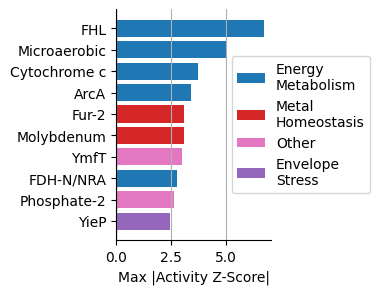

In [22]:
# combine some low-exp-var categories so there aren't too many colors in this plot
category = 'functional_category'
enrichment_categories_to_use  = ['Regulatory']
cmap = 'tab10'
n_top_ims = 10

func_cat_to_var = {}
for func_cat, func_cat_df in p1k_plus_new_data.imodulon_table.groupby(category):
    func_cat_to_var[func_cat] = func_cat_df['exp_var'].sum()
sorted_cat_to_var = sorted(list(func_cat_to_var.items()), key=lambda tup: tup[1], reverse=True)

n_max = 12
other_cats = [tup[0] for tup in sorted_cat_to_var[n_max:]]
func_im_table = p1k_plus_new_data.imodulon_table.copy()
func_im_table = func_im_table.assign(functional_category=func_im_table[category].apply(lambda cat: 'Other' if cat in other_cats else cat.replace(' ', '\n')))

imod_cat_counts = Counter(func_im_table[category])
sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))

zscored_A = p1k_plus_new_data.A.sub(p1k_plus_new_data.A.mean(axis=1), axis=0).divide(p1k_plus_new_data.A.std(axis=1), axis=0)

project_z_acts_sorted = zscored_A[project_metadata.index].abs().max(axis=1).sort_values(ascending=False)

_, ax = plt.subplots(figsize=(2, 3))

ax.xaxis.grid()

bar_count = 0
x_tick_labs = []
cols = ['tab:purple', 'tab:pink', 'tab:red', 'tab:blue']
col_dict = {}
for (im, z_act) in project_z_acts_sorted.iteritems():
    if bar_count < n_top_ims and func_im_table.loc[im]['enrichment_category'] == 'Regulatory':
        im_cat = func_im_table.loc[im][category]
        if im_cat in col_dict:
            ax.barh(n_top_ims - bar_count, z_act, color=col_dict[im_cat])
        else:
            col_to_use = cols.pop()
            ax.barh(n_top_ims - bar_count, z_act, color=col_to_use, label=im_cat)
            col_dict[im_cat] = col_to_use
        bar_count += 1
        x_tick_labs.append(im)
    
for side, s in ax.spines.items():
    if side in ['top', 'right']:
        s.set_visible(False)

ax.set_yticks(range(1, len(x_tick_labs) + 1))
ax.set_yticklabels(x_tick_labs[::-1])
ax.axvline(0, linestyle='--', color='gray', linewidth=1)
ax.set_xlabel('Max |Activity Z-Score|', fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(0.7, 0.5))
plt.savefig(Path(FIG_PATH, 'high_activity_ims.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'high_activity_ims.png'), dpi = 600, bbox_inches = 'tight')

We can also look at the full listing of all iModulons sorted by max absolute z-score within your project, if desired:

In [23]:
pd.set_option('display.max_rows', 250)
project_z_acts_sorted

FHL                   6.701499
SSW SNPs              5.295267
Microaerobic          4.970753
cyoB/kdpE/qseB KO     4.352538
IS Elements-2         4.331546
ymiB                  4.001865
Cytochrome c          3.699599
ArcA                  3.413616
ldrA                  3.314329
sdh KO                3.118014
Fur-2                 3.097277
Molybdenum            3.061305
YmfT                  2.992999
IS Elements-1         2.985492
glrR KO               2.754204
FDH-N/NRA             2.750484
ldrC                  2.695031
Phosphate-2           2.644957
yoaI                  2.428285
YieP                  2.427121
Nitrate/Nitrite       2.405066
YcjW                  2.230844
efeU Activation       2.226860
ythA                  2.203091
entC/ubiC KO-2        2.187263
yafF                  2.178671
NDH-1                 2.177920
Isc System            2.176339
cyoB/ndh/nuoB KO-2    2.095954
SCFA                  2.051763
arcA/luxS KO          2.046118
Sulfate               2.038221
Membrane

In [24]:
pd.set_option('display.max_rows', 60)

# Activity Histogram

An immediately interesting resulting question is: which iModulons have high activity in my project? Activity histograms can answer that question.

We plot, for a given iModulon, the distribution of activities across all projects in P1K, and overlay your project's activities, allowing you to visually assess where your project's activities fall in the overall context of that iModulon's activity in P1K.

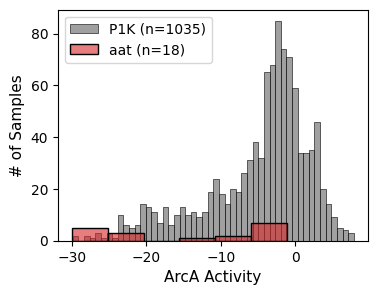

In [25]:
# Change this to look at different iModulons; or wrap this code in a loop to scan many at once
im_of_interest = 'ArcA'

_, ax = plt.subplots(figsize=(4, 3))

sns.histplot(p1k.A.loc[im_of_interest], ax=ax, bins=50, label=f'P1K (n={p1k.A.shape[1]})', color='gray')
sns.histplot(inferred_A.loc[im_of_interest], ax=ax, bins=6, label=f'{PROJECT_NAME} (n={inferred_A.shape[1]})', color='tab:red', alpha=0.6)
ax.legend()
ax.set_xlabel(f'{im_of_interest} Activity', fontsize=11)
ax.set_ylabel('# of Samples', fontsize=11)
plt.savefig(Path(FIG_PATH, 'activity_hist.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'activity_hist.png'), dpi = 600, bbox_inches = 'tight')

# DIMA

An important tool for analysis of transcriptomic data is differential iModulon activity (DIMA) analysis. DIMA analysis parallels differential expression analysis, but reduces the number of variables by over an order of magnitude, enabling a systems-level view of significant changes between two samples.

In our example, let's identify iModulons whose activity changes significantly during this anaerobic to aerobic transition. 

`pymodulon` provides a convenient function `plot_dima` for this purpose

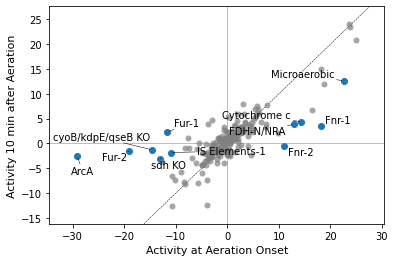

In [278]:
# warnings filter for this specific call as there is a deprecation issue
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dima_ax, dima_table = plot_dima(p1k_plus_new_data, 'aat:00m_00s', 'aat:10m_00s', table=True, fdr=0.05, threshold=9)
    
dima_ax.set_xlabel('Activity at Aeration Onset', fontsize=11)
dima_ax.set_ylabel('Activity 10 min after Aeration', fontsize=11)
plt.savefig(Path(FIG_PATH, 'dima.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'dima.png'), dpi = 600, bbox_inches = 'tight')

We can view the table of the DIMAs that were significant under the provided parameters:

In [24]:
dima_table

,difference,pvalue,qvalue,0,1
ArcA,26.532306,0.000577,0.029232,-29.135889,-2.603583
Fur-2,17.510230,0.002292,0.032180,-19.048747,-1.538516
Fur-1,13.871785,0.005219,0.037463,-11.616098,2.255687
cyoB/kdpE/qseB KO,13.354693,0.000502,0.029232,-14.635924,-1.281231
sdh KO,9.951258,0.000669,0.029232,-12.986958,-3.035700
IS Elements-1,9.175882,0.001775,0.032180,-11.001417,-1.825535
FDH-N/NRA,-9.075610,0.004621,0.036703,12.899085,3.823475
Cytochrome c,-10.009295,0.000888,0.029232,14.389669,4.380374
Microaerobic,-10.012156,0.000256,0.029232,22.627668,12.615512
Fnr-2,-11.475690,0.005038,0.037463,10.956221,-0.519468


# Activity within Project

The `pymodulon.plotting.plot_activities` function can provide quick insights into the activity levels of a given iModulon within your project of interest

/Users/cam/.venv/ica/lib/python3.10/site-packages/pymodulon/plotting.py:111: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bar_vals = metadata.groupby("x").mean()


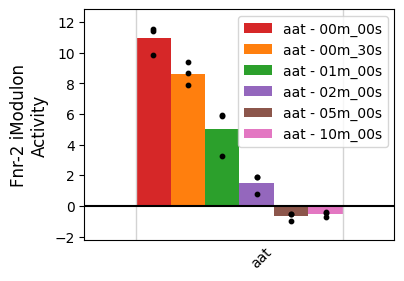

In [26]:
# Change this to look at different iModulons; or wrap this code in a loop to scan many at once
im_of_interest = 'Fnr-2'

_, ax = plt.subplots(figsize=(4, 3))

plot_activities(p1k_plus_new_data, im_of_interest, ax=ax, projects=[PROJECT_NAME], highlight=PROJECT_NAME)

ax.legend()

plt.savefig(Path(FIG_PATH, 'activity_basic.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'activity_basic.png'), dpi = 600, bbox_inches = 'tight')

Since this is time-course data, we can provide a more customized insight into the decrease in anaerobic regulator Fnr's activity during this anaerobic to aerobic transition project.

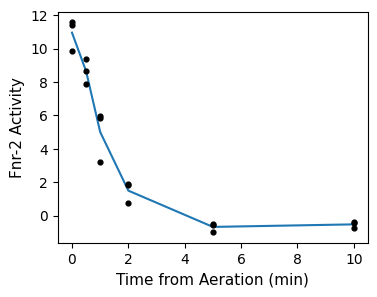

In [27]:
ims_of_interest = 'Fnr-2'
proj_im_acts = inferred_A.loc[im_of_interest]

def get_min(time_str):
    """Get minutes from time."""
    h, m, s = time_str.split(':')
    return int(h) * 60 + int(m) + int(s) / 60

_, ax = plt.subplots(figsize=(4, 3))

plot_times = []
plot_acts = []
for time_str, time_df in project_metadata.groupby('time'):
    time_num = get_min(time_str)
    time_acts = proj_im_acts.loc[time_df.index]
    plot_times.append(time_num)
    plot_acts.append(time_acts.mean())
    ax.scatter([time_num] * len(time_acts), time_acts, s=12, c='k')

ax.plot(plot_times, plot_acts, zorder=-10, color='tab:blue')
ax.set_xlabel('Time from Aeration (min)', fontsize=11)
ax.set_ylabel(f'{im_of_interest} Activity', fontsize=11)
plt.savefig(Path(FIG_PATH, 'activity_time.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'activity_time.png'), dpi = 600, bbox_inches = 'tight')

## Two-Axis Time Course

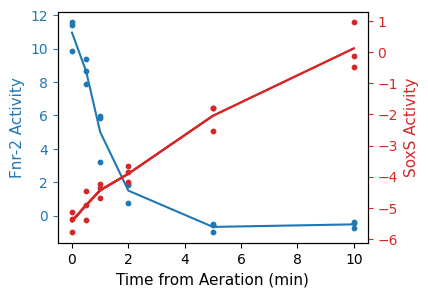

In [28]:
im1 = 'Fnr-2'
im2 = 'SoxS'
proj_im1_acts = inferred_A.loc[im1]
proj_im2_acts = inferred_A.loc[im2]

_, ax1 = plt.subplots(figsize=(4, 3))
ax2 = ax1.twinx()

plot_times = []
plot_acts1 = []
plot_acts2 = []
for time_str, time_df in project_metadata.groupby('time'):
    time_num = get_min(time_str)
    
    time_acts1 = proj_im1_acts.loc[time_df.index]
    plot_times.append(time_num)
    plot_acts1.append(time_acts1.mean())
    ax1.scatter([time_num] * len(time_acts1), time_acts1, s=10, c='tab:blue')
    
    time_acts2 = proj_im2_acts.loc[time_df.index]
    plot_acts2.append(time_acts2.mean())
    ax2.scatter([time_num] * len(time_acts2), time_acts2, s=10, c='tab:red')
    ax2.plot(plot_times, plot_acts2, zorder=-10, color='tab:red')
    
    
ax1.plot(plot_times, plot_acts1, zorder=-10, color='tab:blue')
ax2.plot(plot_times, plot_acts2, zorder=-10, color='tab:red')

ax1.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
ax1.set_ylabel(f'{im1} Activity', fontsize=11, color='tab:blue')

ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
ax2.set_ylabel(f'{im2} Activity', fontsize=11, color='tab:red')

ax1.set_xlabel('Time from Aeration (min)', fontsize=11)
plt.savefig(Path(FIG_PATH, 'activity_time_2im.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'activity_time_2im.png'), dpi = 600, bbox_inches = 'tight')

# Key iM Phase Planes

Certain key iModulons can be compared in a 2-dimensional phase plane to highlight a particular key tradeoff between cellular systems. Plotting your new samples with respect to the remaining samples of PRECISE-1K in the context of one of these phase planes can help to contextualize your samples. 

The built-in `pymodulon` function `compare_activities` allows for generation of these plots; the sub-sections generate more specialized plots that highlight particular points of interest within the selected phase planes.

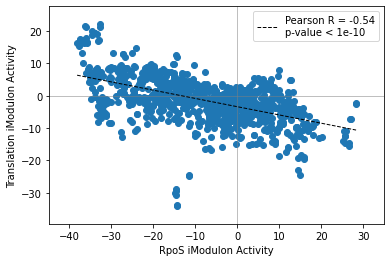

In [221]:
compare_activities(p1k_plus_new_data, 'RpoS', 'Translation')
plt.savefig(Path(FIG_PATH, 'fear_greed_basic.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'fear_greed_basic.png'), dpi = 600, bbox_inches = 'tight')

## Fear/Greed

The fear/greed tradeoff is defined by the Translation and RpoS iModulons. Translation is a proxy for growth/greed, indicating that the cell is in a "comfortable" state where it has energy sources to exploit and minimal stresses to combat. Conversely, RpoS, the global stress sigma factor, captures a broad array of stress responses that cause the cell to "hunker down" and prepare for survival in the face of limited resources or an otherwise hostile environment.

This tradeoff were originally introduced in the original [PRECISE paper](https://www.nature.com/articles/s41467-019-13483-w)

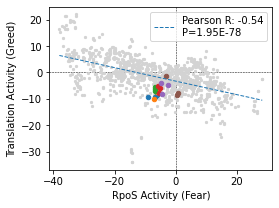

In [254]:
x_im, y_im = 'RpoS', 'Translation'

x_p1k_acts, y_p1k_acts = p1k.A.loc[x_im], p1k.A.loc[y_im]

r, p = pearsonr(x_p1k_acts, y_p1k_acts)

_, ax = plt.subplots(figsize=(4, 3))

ax.plot(np.unique(x_p1k_acts), np.poly1d(np.polyfit(x_p1k_acts, y_p1k_acts, 1))(np.unique(x_p1k_acts)),
        linestyle='--', color='tab:blue', label=f'Pearson R: {r:.2f}\nP={p:.2E}', linewidth=1)

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.scatter(x_p1k_acts, y_p1k_acts, c='lightgray', s=5)

for cond, cond_df in project_metadata.groupby('condition'):
    ax.scatter(inferred_A[cond_df.index].loc[x_im], inferred_A[cond_df.index].loc[y_im], s=20)

ax.set_xlabel('RpoS Activity (Fear)', fontsize=10)
ax.set_ylabel('Translation Activity (Greed)', fontsize=10)

ax.legend(loc='upper right')
plt.savefig(Path(FIG_PATH, 'fear_greed_custom.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'fear_greed_custom.png'), dpi = 600, bbox_inches = 'tight')

## Fur

Fur (ferric uptake regulator) is a critical global regulator of iron homeostasis and also relevant for redox/aerobicity. In our example project, both Fur iModulons (Fur-1 and Fur-2, which capture related but ultimately distinct subsets of the large Fur regulon) appeared as significantly increased activity 10 minutes after aeration of the culture.

This tradeoff was originally discussed in a [paper](https://journals.asm.org/doi/full/10.1128/mSphere.00443-21) that used PRECISE to analyze antibiotic responses

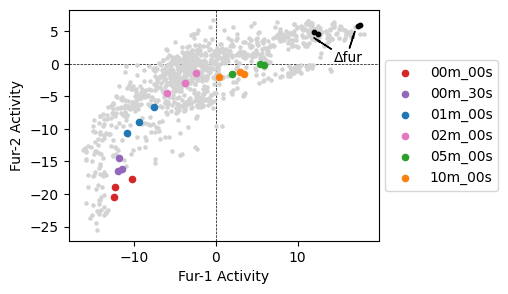

In [30]:
x_im, y_im = 'Fur-1', 'Fur-2'

x_p1k_acts, y_p1k_acts = p1k.A.loc[x_im], p1k.A.loc[y_im]

del_fur_conds = p1k.sample_table[p1k.sample_table['Strain Description'].str.contains('del_fur')].index

_, ax = plt.subplots(figsize=(4, 3))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.scatter(x_p1k_acts, y_p1k_acts, c='lightgray', s=5)

ax.scatter(p1k.A[del_fur_conds].loc[x_im], p1k.A[del_fur_conds].loc[y_im], c='k', s=10)

ax.annotate('Δfur', (12, 4), ha='right', va='top', xytext=(18, 2), arrowprops={'headlength': 5, 'width':0.2, 'headwidth': 1}, color='white')
ax.annotate('Δfur', (17,  5), ha='right', va='top', xytext=(18, 2), arrowprops={'headlength': 5, 'width':0.2, 'headwidth': 1})

cols = [
    'tab:red', 'tab:purple', 'tab:blue', 'tab:pink', 'tab:green', 'tab:orange'
]
for col, (cond, cond_df) in zip(cols, project_metadata.groupby('condition')):
    ax.scatter(inferred_A[cond_df.index].loc[x_im], inferred_A[cond_df.index].loc[y_im], label=cond, s=20, c=col)

ax.set_xlabel(f'{x_im} Activity', fontsize=10)
ax.set_ylabel(f'{y_im} Activity', fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(Path(FIG_PATH, 'fur.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'fur.png'), dpi = 600, bbox_inches = 'tight')

## Fnr/ArcA

This tradeoff directly highlights aerobic/anaerobic tradeoff, with a major global regulator of anaerobic metabolism (Fnr) contrasted with ArcA, a global regulator which represses aerobic metabolism genes under anaerobiosis, and thus whose constituent genes are active under aerobic conditions.

This tradeoff was again originally discussed in the antibiotic susceptibility paper highlighted for the Fur tradeoff above.

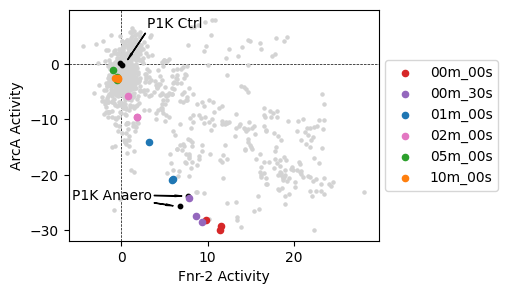

In [31]:
x_im, y_im = 'Fnr-2', 'ArcA'

x_p1k_acts, y_p1k_acts = p1k.A.loc[x_im], p1k.A.loc[y_im]

has_e = p1k.sample_table[p1k.sample_table['Electron Acceptor'].notna()]
anaero_conds = has_e[has_e['Electron Acceptor'].str.contains('N')].index
ctrl_conds = ['p1k_00001', 'p1k_00002']

_, ax = plt.subplots(figsize=(4, 3))

ax.axvline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.axhline(0, linestyle='--', color='black', zorder=-1, linewidth=0.5)
ax.scatter(x_p1k_acts, y_p1k_acts, c='lightgray', s=5)

ax.scatter(p1k.A[anaero_conds].loc[x_im], p1k.A[anaero_conds].loc[y_im], c='k', s=10)
ax.annotate('P1K Anaero', (7, -23.828039), ha='right', va='bottom', xytext=(3.5, -25), arrowprops={'headlength': 5, 'width':0.2, 'headwidth': 1}, color='white')
ax.annotate('P1K Anaero', (6,  -25.597415), ha='right', va='bottom', xytext=(3.5, -25), arrowprops={'headlength': 5, 'width':0.2, 'headwidth': 1})

ax.scatter(p1k.A[ctrl_conds].loc[x_im], p1k.A[ctrl_conds].loc[y_im], c='k', s=10)
ax.annotate('P1K Ctrl', (0.75, 0.75), ha='left', va='bottom', xytext=(3, 6), arrowprops={'headlength': 5, 'width':0.2, 'headwidth': 1})

cols = [
    'tab:red', 'tab:purple', 'tab:blue', 'tab:pink', 'tab:green', 'tab:orange'
]
for col, (cond, cond_df) in zip(cols, project_metadata.groupby('condition')):
    ax.scatter(inferred_A[cond_df.index].loc[x_im], inferred_A[cond_df.index].loc[y_im], label=cond, s=20, c=col)

ax.set_xlabel(f'{x_im} Activity', fontsize=10)
ax.set_ylabel(f'{y_im} Activity', fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(Path(FIG_PATH, 'fnr_arca.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'fnr_arca.png'), dpi = 600, bbox_inches = 'tight')

# iM Activity Clusters

Clustering the activities of iModulons across samples can indicate groups of iModulons whose activities are correlated; these in turn may correspond to stimulons, or groups of regulators/genes that respond to a particular environmental stimulus at the systems level. 

`pymodulon` has the `cluster_activities` function to support this particular investigation.

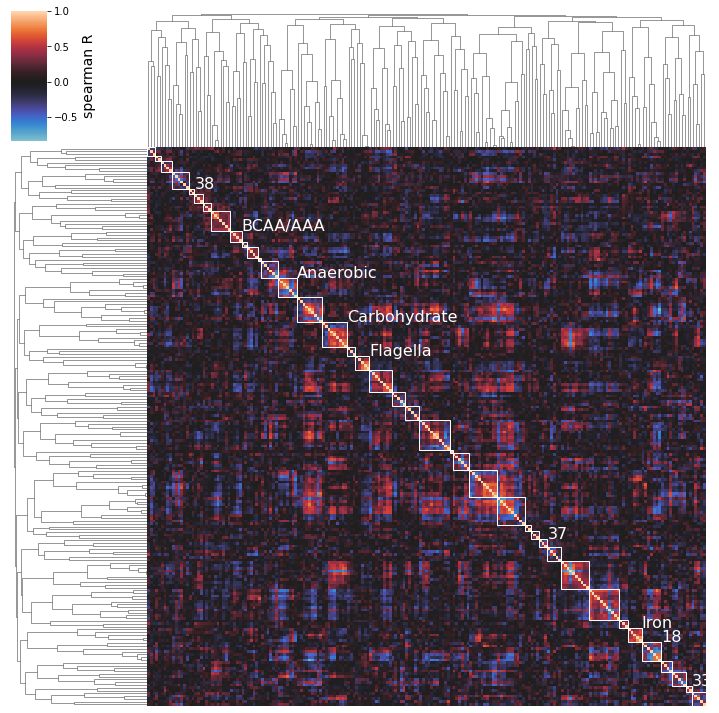

Text(21.875, 0.5, 'Activity 10 min after Aeration')

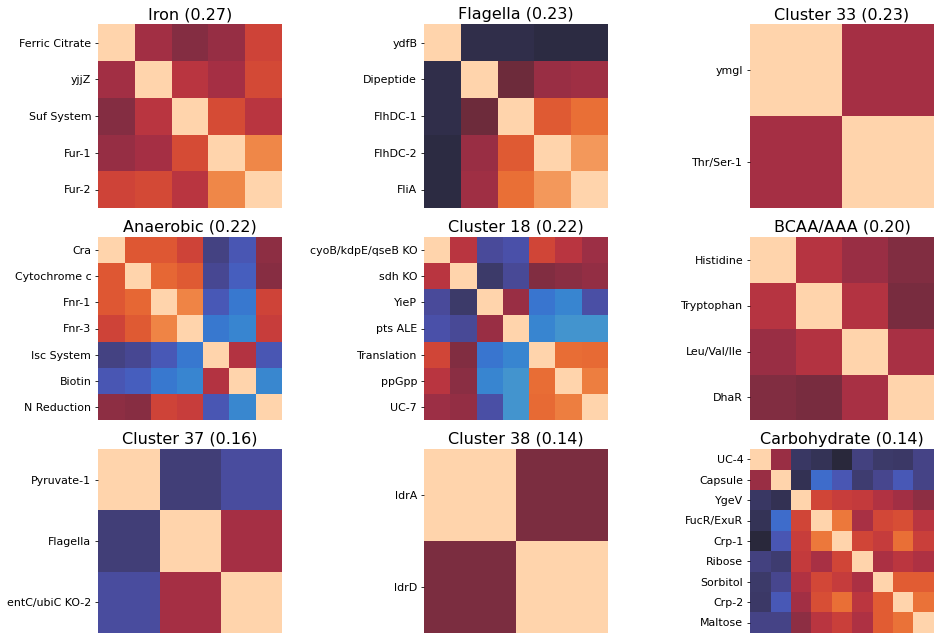

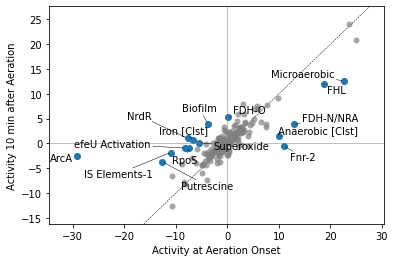

In [225]:
# warnings filter for this specific call as there is a deprecation issue
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clusters, dimca_ax, dimca_table = cluster_activities(p1k_plus_new_data, distance_threshold=0.85, show_best_clusters=True, n_best_clusters=9,
                       cluster_names={20: 'Iron', 9: 'Flagella', 36: 'Anaerobic', 30: 'BCAA/AAA', 0: 'Carbohydrate'},
                      dimca_sample1='aat:00m_00s', dimca_sample2='aat:10m_00s', dimca_table=True)
    
dimca_ax.set_xlabel('Activity at Aeration Onset', fontsize=10)
dimca_ax.set_ylabel('Activity 10 min after Aeration', fontsize=10)

In [32]:
dimca_table

,difference,pvalue,qvalue,0,1
ArcA,26.532306,0.000577,0.036841,-29.135889,-2.603583
IS Elements-1,9.175882,0.001775,0.036841,-11.001417,-1.825535
Putrescine,8.997248,0.001396,0.036841,-12.663230,-3.665982
NrdR,8.765668,0.001570,0.036841,-7.714201,1.051467
Biofilm,7.748006,0.003162,0.038801,-3.774439,3.973567
efeU Activation,7.376600,0.001018,0.036841,-8.289557,-0.912957
Iron [Clst],7.222012,0.003974,0.038801,-6.620732,0.601280
RpoS,6.542210,0.024256,0.091513,-7.356953,-0.814743
Superoxide,5.554738,0.000835,0.036841,-5.432243,0.122495
FDH-O,5.226601,0.001702,0.036841,0.151592,5.378193


# Condition Similarity

The activity profiles of the conditions in PRECISE-1K and your project can be used to draw similarities between them in a couple of ways. We can use PCA to analyze the major dimensions of variance between samples across iModulons as variables. Or we can use a similarity metric (such as Spearman correlation) to cluster samples. We will explore both approaches here to help elucidate which samples from your project are similar to which from PRECISE-1K, from an iModulon activity perspective. 

## PCA-based

Using PCA will allow us to very broadly assess where the new samples reside in principal component space

In [226]:
pca = PCA()

A_standard = pd.DataFrame(StandardScaler().fit_transform(p1k_plus_new_data.A.T), index=p1k_plus_new_data.A.T.index, columns=p1k_plus_new_data.A.T.columns)

DF_weights = pd.DataFrame(pca.fit_transform(A_standard), index=A_standard.index)
DF_components = pd.DataFrame(pca.components_.T, index=A_standard.columns)

### Explained Variance

Number of dimensions for 95% of variance: 106


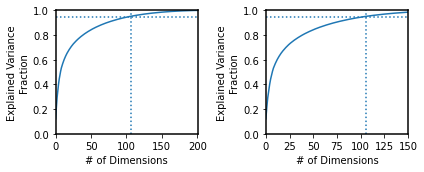

In [227]:
# Set the explained variance threshold
var_cutoff = 0.95

fig, (ax_all, ax_close) = plt.subplots(1, 2, figsize=(6,2.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax_all.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_all.vlines(dims,0,1,linestyles='dotted')
ax_all.hlines(var_cutoff,0,len(A_standard.columns),linestyles='dotted')
ax_all.set_ylim(0,1)
ax_all.set_xlim(0,len(A_standard.columns))
ax_all.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_all.set_xlabel('# of Dimensions',fontsize=10)
ax_all.set_xticks(np.arange(0, 210, 50))
for s in ax_all.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
ax_close.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax_close.vlines(dims,0,1,linestyles='dotted')
ax_close.hlines(var_cutoff,0,len(A_standard.columns),linestyles='dotted')
ax_close.set_ylim(0,1)
ax_close.set_xlim(0,150)
ax_close.set_ylabel('Explained Variance\nFraction',fontsize=10)
ax_close.set_xlabel('# of Dimensions',fontsize=10)
ax_close.set_xticks(np.arange(0, 160, 25))
for s in ax_close.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
print(f'Number of dimensions for {var_cutoff*100:.0f}% of variance:', dims)
plt.tight_layout()

### First 2 Components

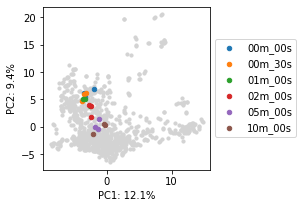

In [283]:
fig,ax = plt.subplots(figsize=(3,3))
    
p1k_idx = p1k.sample_table.index
    
ax.scatter(DF_weights.loc[p1k_idx,0], DF_weights.loc[p1k_idx,1], s=10, c='lightgray')

for cond, cond_df in project_metadata.groupby('condition'):
    ax.scatter(DF_weights.loc[cond_df.index,0], DF_weights.loc[cond_df.index,1], label=cond, s=20)

ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(Path(FIG_PATH, 'pca_cond_a.svg'), dpi = 600, bbox_inches = 'tight')
plt.savefig(Path(FIG_PATH, 'pca_cond_a.png'), dpi = 600, bbox_inches = 'tight')

PC2 has high weightings of anaerobic-related iMs, so it makes sense that the samples from our example project that are closer to the anaerobic/aerobic transition are higher in this dimension. 

## Pairwise Correlations

For a more granular assessment of specific PRECISE-1K samples that are similar to your samples, we can use pairwise correlations.

In [229]:
corr_threshold = 0.5

pairwise_corrs_for_new = p1k_plus_new_data.A.corr(method='spearman').loc[project_metadata.index][p1k.sample_table.index]

top_corrs_by_proj_idx = {}

for proj_idx, proj_corr_row in pairwise_corrs_for_new.iterrows():
    top_corrs_for_samp = proj_corr_row.abs().sort_values(ascending=False)
    corrs_over_threshold = top_corrs_for_samp[top_corrs_for_samp > corr_threshold]
    p1k_md_for_high_corrs = p1k.sample_table.loc[corrs_over_threshold.index]
    p1k_md_for_high_corrs['spearman_corr'] = corrs_over_threshold.values
    top_corrs_by_proj_idx[proj_idx] = p1k_md_for_high_corrs

Using this lookup, we can identify samples from PRECISE-1K that are correlated with our sample of interest from our new project:

In [232]:
sample_id_of_interest = 'SRX1125282'

top_corrs_by_proj_idx[sample_id_of_interest]

,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,creator,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates,run_date,spearman_corr
p1k_00073,minspan__wt_glc_anaero__1,MinSpan,minspan,wt_glc_anaero,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Haythem Latif,True,True,True,True,minspan:wt_glc_anaero,True,True,10/1/12,0.742817
p1k_00054,omics__wt_thr__1,Omics,omics,wt_thr,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Donghyuk Kim,True,True,True,True,omics:wt_thr,True,True,7/7/14,0.709803
p1k_00151,ssw__xyl_ale1__1,Substrate-switching Evolution,ssw,xyl_ale1,1,Escherichia coli SSW_XYL.1.20.1,MG1655,Batch,Endpoint,M9,...,Ying Hefner,True,False,True,True,ssw:xyl_ale1,True,False,4/18/17,0.706990
p1k_00055,omics__wt_thr__2,Omics,omics,wt_thr,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Donghyuk Kim,True,True,True,True,omics:wt_thr,True,True,7/7/14,0.683125
p1k_00074,minspan__wt_glc_anaero__2,MinSpan,minspan,wt_glc_anaero,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Haythem Latif,True,True,True,True,minspan:wt_glc_anaero,True,True,10/1/12,0.652231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p1k_00548,ros_tale__1_2_250pq__1,ROS TALE,ros_tale,1_2_250pq,1,Escherichia coli ERS.13.87,GMOS,Batch,Endpoint,M9,...,Justin Tan,True,True,True,True,ros_tale:1_2_250pq,True,True,10/30/19,0.501255
p1k_00606,ros_tale__2_3_0pq__1,ROS TALE,ros_tale,2_3_0pq,1,Escherichia coli ERS.29.119,GMOS,Batch,Endpoint,M9,...,Justin Tan,True,True,True,True,ros_tale:2_3_0pq,True,True,10/30/19,0.501216
p1k_00144,ssw__wt_glyc__1,Substrate-switching Evolution,ssw,wt_glyc,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,Ying Hefner,True,True,True,True,ssw:wt_glyc,True,True,4/18/17,0.500746
p1k_00506,tcs__wt_m9p__2,Two Component Systems,tcs,wt_m9p,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9P,...,Julia Kleinmanns,True,True,True,True,tcs:wt_m9p,True,True,9/20/19,0.500711


And then we can plot in principal-component space the similar PRECISE-1K samples for a particular sample from your project:

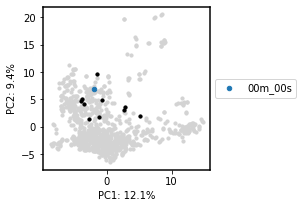

In [282]:
n_top_points = 10

fig,ax = plt.subplots(figsize=(3,3))

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1.5)
    
p1k_idx = p1k.sample_table.index
    
ax.scatter(DF_weights.loc[p1k_idx,0], DF_weights.loc[p1k_idx,1], s=10, c='lightgray')

ax.scatter(DF_weights.loc[sample_id_of_interest,0], DF_weights.loc[sample_id_of_interest,1], label=project_metadata.loc[sample_id_of_interest]['condition'], s=20)

for p1k_pt_idx, p1k_similar_row in top_corrs_by_proj_idx[sample_id_of_interest][:n_top_points].iterrows():
    ax.scatter(DF_weights.loc[p1k_pt_idx,0], DF_weights.loc[p1k_pt_idx,1], s=10, c='black')

ax.set_xlabel('PC1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=10)
ax.set_ylabel('PC2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=10)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))